# GD10. Transformer로 번역기 만들기
```
$ sudo apt -qq -y install fonts-nanum
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

import pandas as pd
import sentencepiece as spm

## 내부 모듈 구현하기
### Positional Encoding

In [3]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

### Multi-Head Attention
* ```MultiHeadAttention``` 클래스: 여러 개의 서브모듈 결합해 완성
    - ```split_heads()```: embedding된 입력을 head 수로 분할
    - ```scaled_dot_product_attention()```: 분할된 입력으로부터 attention 값을 구함
    - ```combine_heads()```: 연산이 종료되고 분할된 head를 다시 하나로 결합
* masking: 마스크의 형태를 결정하는 게 모델 외부의 훈련 데이터이기 때문에, MultiHeadAttention 외부에 정의할 것

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        self.depth = d_model // self.num_heads
        
        self.W_q = tf.keras.layers.Dense(d_model) # Linear Layer
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)

        """
        Scaled QK 값 구하기
        """
        QK = tf.matmul(Q, K, transpose_b=True)
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9) 

        """
        1. Attention Weights 값 구하기 -> attentions
        2. Attention 값을 V에 곱하기 -> out
        """ 
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
        

    def split_heads(self, x):
        """
        Embedding을 Head의 수로 분할하는 함수

        x: [ batch x length x emb ]
        return: [ batch x length x heads x self.depth ]
        """
        
        bsz = x.shape[0]
        split_x = tf.reshape(x, (bsz, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        """
        분할된 Embedding을 하나로 결합하는 함수

        x: [ batch x length x heads x self.depth ]
        return: [ batch x length x emb ]
        """
        
        bsz = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (bsz, -1, self.d_model))

        return combined_x
    

    def call(self, Q, K, V, mask):
        """
        아래 순서에 따라 소스를 작성하세요.

        Step 1: Linear_in(Q, K, V) -> WQ, WK, WV
        Step 2: Split Heads(WQ, WK, WV) -> WQ_split, WK_split, WV_split
        Step 3: Scaled Dot Product Attention(WQ_split, WK_split, WV_split)
                 -> out, attention_weights
        Step 4: Combine Heads(out) -> out
        Step 5: Linear_out(out) -> out

        """
        
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        out, attention_weights = self.scaled_dot_product_attention(WQ_splits, WK_splits, WV_splits, mask)
        
        out = self.combine_heads(out)
        out = self.linear(out)

        return out, attention_weights

### Position-wise Feed-Forward Network
* [batch x length x d_model] 의 입력을 받아 w_1이 2048차원으로 매핑하고 활성함수 ReLU를 적용한 후, 다시 w_2를 통해 512차원으로 되돌리는 과정
* 논문에 따르면,
    * ```d_ff```: 2048
    * ```d_model```: 512

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

## 모듈 조립하기
* 원하는 만큼 레이어를 쌓아 많은 수의 실험을 자유자재로 할 수 있기 위해서는, 모델이 동적으로 완성될 수 있게씀 만들 필요가 있다
    - (텐서플로우의 Dense 레이어 사용하듯) EncoderLayer, DecoderLayer를 쓸 수 있게 ```tf.keras.layers.Layer``` 클래스를 상속받아 레이어 클래스로 정의
    
```
N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```

### Encoder 레이어 구현

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual
        
        return out, enc_attn

### Decoder 레이어 구현
* 논문에서는 [Input] - [Module] - [Residual] - [Norm] (Module = MHA, FFN) 으로 표현되어 있지만,
* Official (Google Tensor2Tensor) 에서는 [Input] - [Norm] - [Module] - [Residual] 방식 사용

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        self.dec_self_attn = MultiHeadAttention(d_model, n_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, n_heads)
        
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, enc_out, causality_mask, padding_mask):
        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        # out, dec_attn = self.dec_self_attn(out, out, out, causality_mask)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.do(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, padding_mask)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.do(out)
        out += residual

        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
    
        self.do = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

### Transformer 완성하기
* 조건
    1. shared 변수를 매개변수로 받아 True 일 경우 Decoder Embedding과 출력층 Linear의 Weight를 공유할 수 있게 하세요! Weight가 공유될 경우 Embedding 값에 sqrt(d_model)을 곱해줘야 하는 것, 잊지 않으셨죠? (참고: tf.keras.layers.Layer.set_weights())
    2. 우리가 정의한 positional_encoding 의 반환값 형태는 [ Length x d_model ] 인데, 이를 더해 줄 Embedding 값 형태가 [ Batch x Length x d_model ] 이라서 연산이 불가능합니다. 연산이 가능하도록 수정하세요! (참고: tf.expand_dims(), np.newaxis)

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared_fc=True,
                    shared_emb=False):
        super(Transformer, self).__init__()

        self.d_model = tf.cast(d_model, tf.float32)

        if shared_emb:
            self.enc_emb = self.dec_emb = \
            tf.keras.layers.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
            self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.do = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared_fc = shared_fc

        if shared_fc:
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]

        out = emb(x)

        if self.shared_fc: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.do(out)

        return out


    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)

        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)

        logits = self.fc(dec_out)

        return logits, enc_attns, dec_attns, dec_enc_attns

## 모델 밖의 조력자들
### Masking
* ```generate_padding_mask()```: Attention을 할 때 \<PAD\> 토큰에도 Attention을 주는 것을 방지해 주는 역할. 한 배치의 데이터에서 \<PAD\> 토큰으로 이뤄진 부분을 모두 찾아내는 마스크 생성

In [11]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

* 눈으로 직접 확인
    - 첫 번째 마스크: 각 배치 별로 데이터의 꼬리 부분을 masking하는 형태
    - 두 번째, 세 번째 마스크: causality mask와 padding mask를 결합한 형태. 자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 했는데, 인과 관계를 가리는 것도 중요하지만 Decoder 역시 \<PAD\> 토큰은 피해 가야 하기 때문에 이런 형태의 마스크를 사용

In [ ]:
'''
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()
'''

In [12]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## 프로젝트: 더 멋진 번역기 만들기

### 데이터 다운로드
* https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1

### 데이터 정제 및 토큰화
* ```set``` 으로 중복 데이터 제거 (병렬 쌍 흐트러지지 않게 주의)
* 중복 제거한 데이터를 ```cleaned_corpus```에 저장
* 아래 조건을 만족하는 정제 함수 정의
    - 모든 입력을 소문자로 변환
    - 알파벳, 문장부호, 한글만 남기고 모두 제거
    - 문장부호 양 옆에 공백 추가
    - 문장 앞뒤 불필요한 공백 제거
* 한글 말뭉치 ```kor_corpus```와 영문 말뭉치 ```eng_corpus``` 분리 후, 정제해 토큰화 진행 (토큰화에는 sentencepiece 활용할 것) 공식 사이트 (https://github.com/google/sentencepiece) 를 참고해 ```generate_tokenizer()``` 정의
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있어야 함
    - 학습 후 저장된 model 파일을 ```SentencePieceProcessor()``` 클래스에 ```Load()``` 한 후 반환
    - 특수 토큰의 인덱스 지정: PAD: 0 / BOS: 1 / EOS: 2 / UNK: 3
* 최종적으로 ko_tokenizer 과 en_tokenizer 생성
    - en_tokenizer에는 ```set_encode_extra_options("bos:eos")``` 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있도록 할 것
* 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고 텐서 enc_train 과 dec_train 으로 변환

In [13]:
# 데이터 로드
train_ko_path = "transformer/korean-english-park.train.ko"
train_en_path = "transformer/korean-english-park.train.en"

# 한국어 데이터 오픈
with open(train_ko_path, "r") as f:
    train_ko_raw = f.read().splitlines()
    
# 영어 데이터 오픈
with open(train_en_path, "r") as f:
    train_en_raw = f.read().splitlines()

In [14]:
# 중복 제거 (set() 대신 pandas dataframe 사용)

print('before:', len(train_ko_raw))

# 중복 제거를 위해 dataframe 생성
train_raw = pd.DataFrame({'ko': train_ko_raw, 'en': train_en_raw})
# train_raw.drop_duplicates(subset=['ko'], inplace=True)
# 두 언어 모두 같은 문장일 때만 중복으로 보고 제거
train_raw.drop_duplicates(inplace=True)

print('after:', len(train_raw))

train_raw.head()

before: 94123
after: 78968


,ko,en
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


In [15]:
# cleaned_corpus 생성
cleaned_corpus_ko = list(train_raw['ko'])
cleaned_corpus_en = list(train_raw['en'])

print(cleaned_corpus_ko[20])
print(cleaned_corpus_en[20])

북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.


In [16]:
# 정제 함수 정의
def preprocess_sentence(sentence):
    # 소문자 변환
    sentence = sentence.lower()
    
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    
    # 문장부호 양 옆에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    
    # 앞뒤 공백 제거 (위 작업에서 새로운 공백이 생길 수 있기 때문에, 맨 나중에 해야 한다고 판단)
    sentence = sentence.strip()
    
    return sentence

kor_corpus = []
eng_corpus = []

for corpus in cleaned_corpus_ko:
    kor_corpus.append(preprocess_sentence(corpus))
    
for corpus in cleaned_corpus_en:
    eng_corpus.append(preprocess_sentence(corpus))
    
print("korean corpus:", len(kor_corpus))
print("english corpus:", len(eng_corpus))
    
print(kor_corpus[20])
print(eng_corpus[20])

korean corpus: 78968
english corpus: 78968
북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데 ,  일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다 .
amid mounting pressure on north korea to abandon its nuclear weapons program japanese and north korean diplomats have resumed talks on normalizing diplomatic relations .


In [17]:
# https://donghwa-kim.github.io/SPM.html

# SentencePiece 로 토큰화
def generate_tokenizer(corpus, path, filename):
    templates= '--input={} \
    --pad_id={} \
    --bos_id={} \
    --eos_id={} \
    --unk_id={} \
    --model_prefix={} \
    --vocab_size={} \
    --character_coverage={} \
    --model_type={}'
    
    with open(path + filename, "w") as f:
        for sentence in corpus:
            f.write('{}\n'.format(sentence))

    train_input_file = path + filename
    pad_id = 0  # <PAD> token을 0으로 설정
    vocab_size = 20000 # vocab 사이즈
    prefix = filename + '_spm' # 저장될 tokenizer 모델에 붙는 이름
    bos_id = 1 # <BOS> token을 1으로 설정
    eos_id = 2 # <EOS> token을 2으로 설정
    unk_id = 3 # <UNK> token을 3으로 설정
    character_coverage = 1.0 # to reduce character set 
    model_type ='unigram' # Choose from unigram (default), bpe, char, or word

    cmd = templates.format(train_input_file,
                    pad_id,
                    bos_id,
                    eos_id,
                    unk_id,
                    prefix,
                    vocab_size,
                    character_coverage,
                    model_type)
    
    spm.SentencePieceTrainer.Train(cmd)
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(path + "%s.model" % prefix)
    
    return tokenizer
    
kor_tokenizer = generate_tokenizer(kor_corpus, "", "ko.txt")
eng_tokenizer = generate_tokenizer(eng_corpus, "", "en.txt")

In [18]:
eng_tokenizer.set_encode_extra_options('bos:eos')

True

In [19]:
source = []
target = []

for i in range(0, len(kor_corpus)):
    curr_ko = kor_tokenizer.EncodeAsIds(kor_corpus[i])
    curr_en = eng_tokenizer.EncodeAsIds(eng_corpus[i])
    
    if len(curr_ko) > 50: continue
    if len(curr_en) > 50: continue
    
    source.append(curr_ko)
    target.append(curr_en)

In [20]:
enc_train = tf.keras.preprocessing.sequence.pad_sequences(source, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(target, padding='post')

print(enc_train.shape)
print(dec_train.shape)

(68037, 50)
(68037, 50)


### 훈련
* 2 Layer를 가지는 트랜스포머를 선언하세요. 하이퍼파라미터는 자유롭게 조절합니다.
* 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.
* Loss 함수를 정의하세요. Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문)
* 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.
* 매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!

In [21]:
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.3
vocab_size = 20000

# transformer 선언 (위 실습에서 주어진 클래스 활용)
transformer = Transformer(n_layers=n_layers,
                         d_model=d_model,
                         n_heads=n_heads,
                         d_ff=d_ff,
                         dropout=dropout,
                         src_vocab_size=vocab_size,
                         tgt_vocab_size=vocab_size,
                         pos_len=200,
                         shared_fc=True,
                         shared_emb=True)

In [22]:
# learning rate scheduler 선언 (위 실습에서 주어진 클래스 활용)
learning_rate = LearningRateScheduler(d_model)

In [23]:
# optimizer (adam) 선언
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                    beta_1=0.9,
                                    beta_2=0.98,
                                    epsilon=1e-9)

In [24]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [25]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    tgt_in = tgt[:, :-1]
    gold = tgt[:, 1:]

    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss, enc_attns, dec_attns, dec_enc_attns

In [26]:
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [27]:
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [28]:
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [29]:
sentences = ['오바마는 대통령이다.', '시민들은 도시 속에 산다.', '커피는 필요 없다.', '일곱 명의 사망자가 발생했다.']

In [31]:
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss

        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    if epoch < EPOCHS:
        for sen in sentences:
            translate(sen, transformer, kor_tokenizer, eng_tokenizer)
    
    else:
        for sen in sentences:
            translate(sen, transformer, kor_tokenizer, eng_tokenizer, plot_attention = True)

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



Input: 오바마는 대통령이다.
Predicted translation: obama has been elected by president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they were taken into the city of the city .
Input: 커피는 필요 없다.
Predicted translation: then s not immediately , but i don t want to be able to be able to be able to be able .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the blast occurred wednesday .



Input: 오바마는 대통령이다.
Predicted translation: obama is a candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s largest city .
Input: 커피는 필요 없다.
Predicted translation: it needs to be a key .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: deaths died tuesday , killing people .



Input: 오바마는 대통령이다.
Predicted translation: obama s president has been a president in the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the town of cities in the city of yogyakarta .
Input: 커피는 필요 없다.
Predicted translation: coffee does not need a problem .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the killed six people and wounded .



Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the city of san diego .
Input: 커피는 필요 없다.
Predicted translation: there is no need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the city of , people were killed .



Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is one of the city of san jose luis de jesuses .
Input: 커피는 필요 없다.
Predicted translation: no need need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died sunday when the death toll was .



Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is built in the city of shies .
Input: 커피는 필요 없다.
Predicted translation: no need need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died sunday after the storm .



Input: 오바마는 대통령이다.
Predicted translation: president barack obama is .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is one of the city .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed when seven others were wounded .



Input: 오바마는 대통령이다.
Predicted translation: president obama is winning the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is one of the city was freed in san francisco .
Input: 커피는 필요 없다.
Predicted translation: no agreement needed to be removed from coffee electronic malcolm coffee or coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died in sunday , injuries .



Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is one of the city s busiest .
Input: 커피는 필요 없다.
Predicted translation: speaking during a discussion from coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people died on monday .



Input: 오바마는 대통령이다.
Predicted translation: president obama is winning the democratic presidential nomination .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is the city of rural towns .
Input: 커피는 필요 없다.
Predicted translation: there are no need to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on monday .


Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died on monday .
Encoder Layer 1


/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


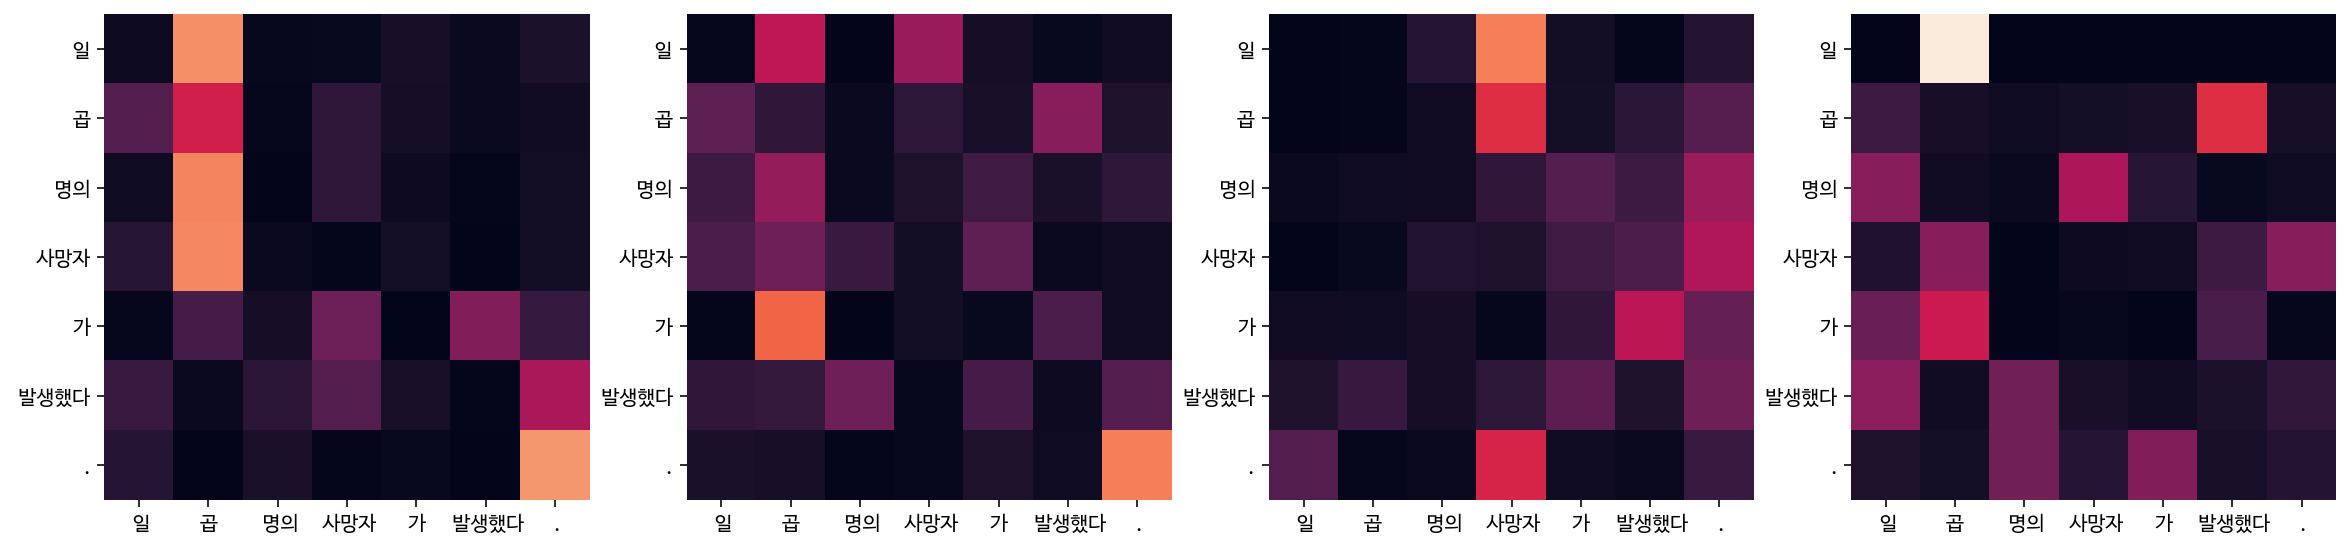

Encoder Layer 2


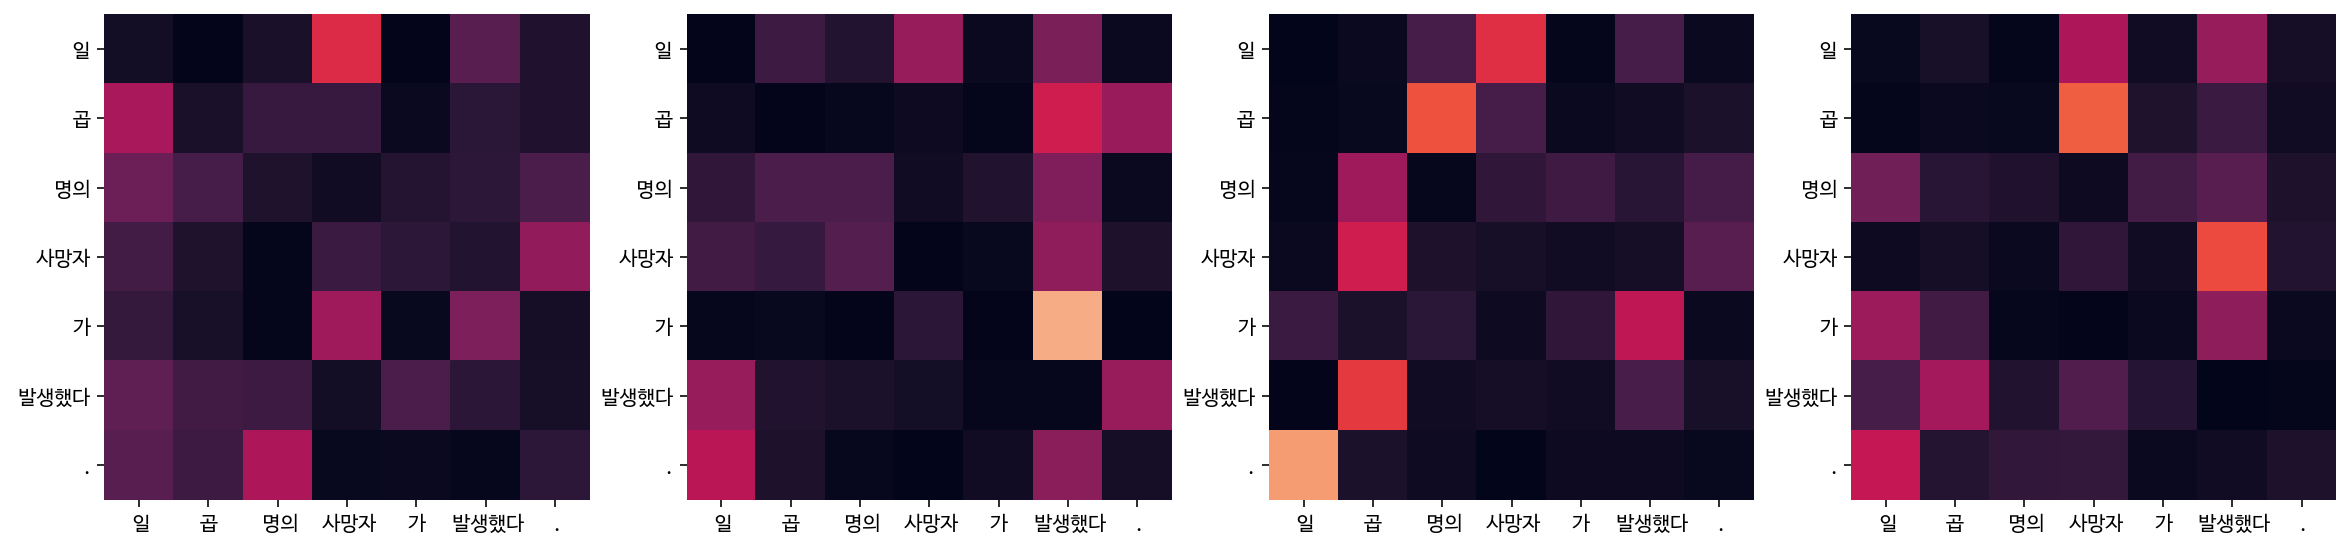

Decoder Self Layer 1


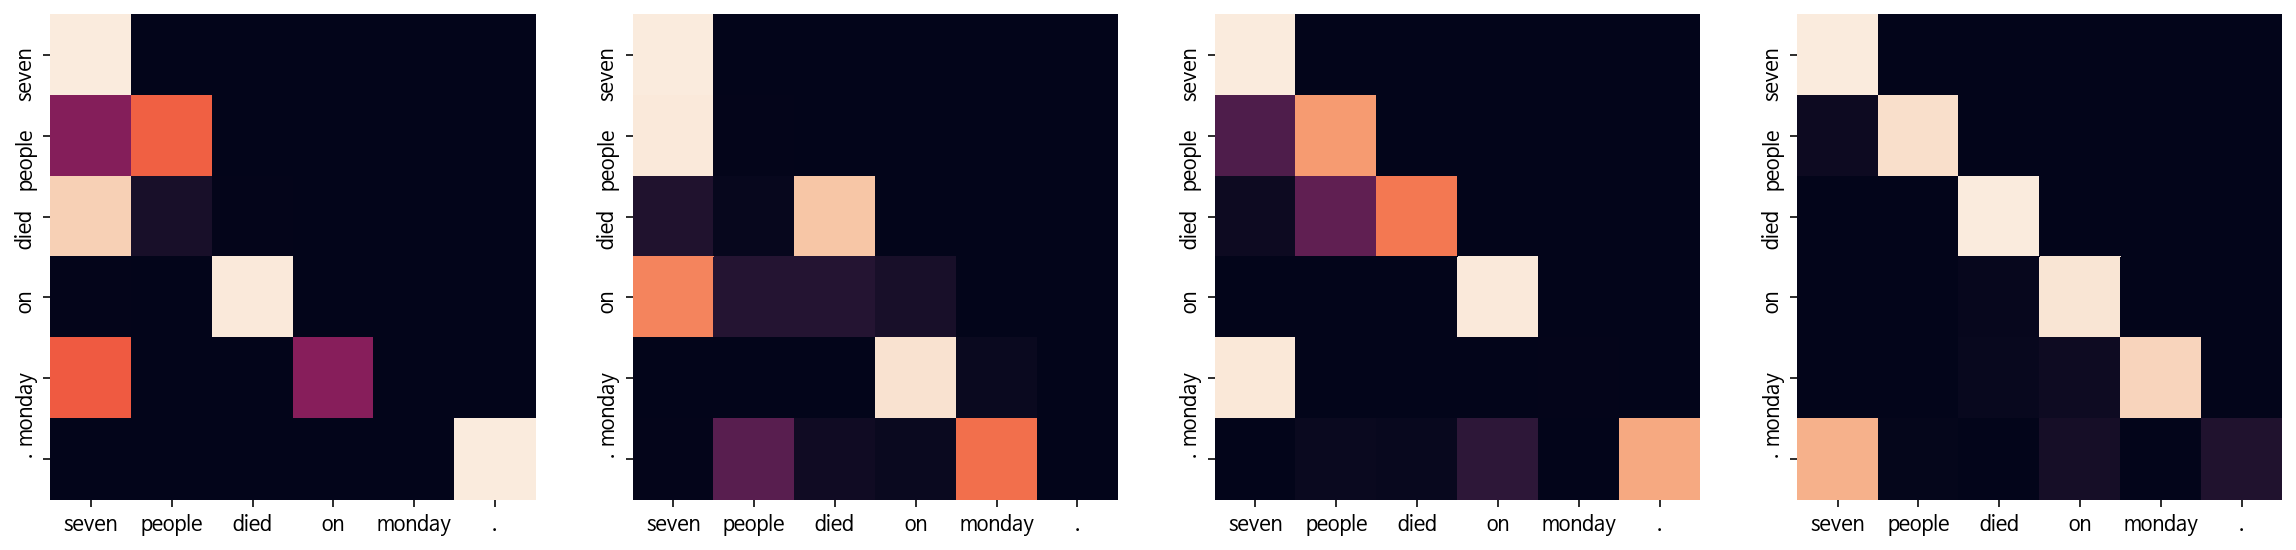

Decoder Src Layer 1


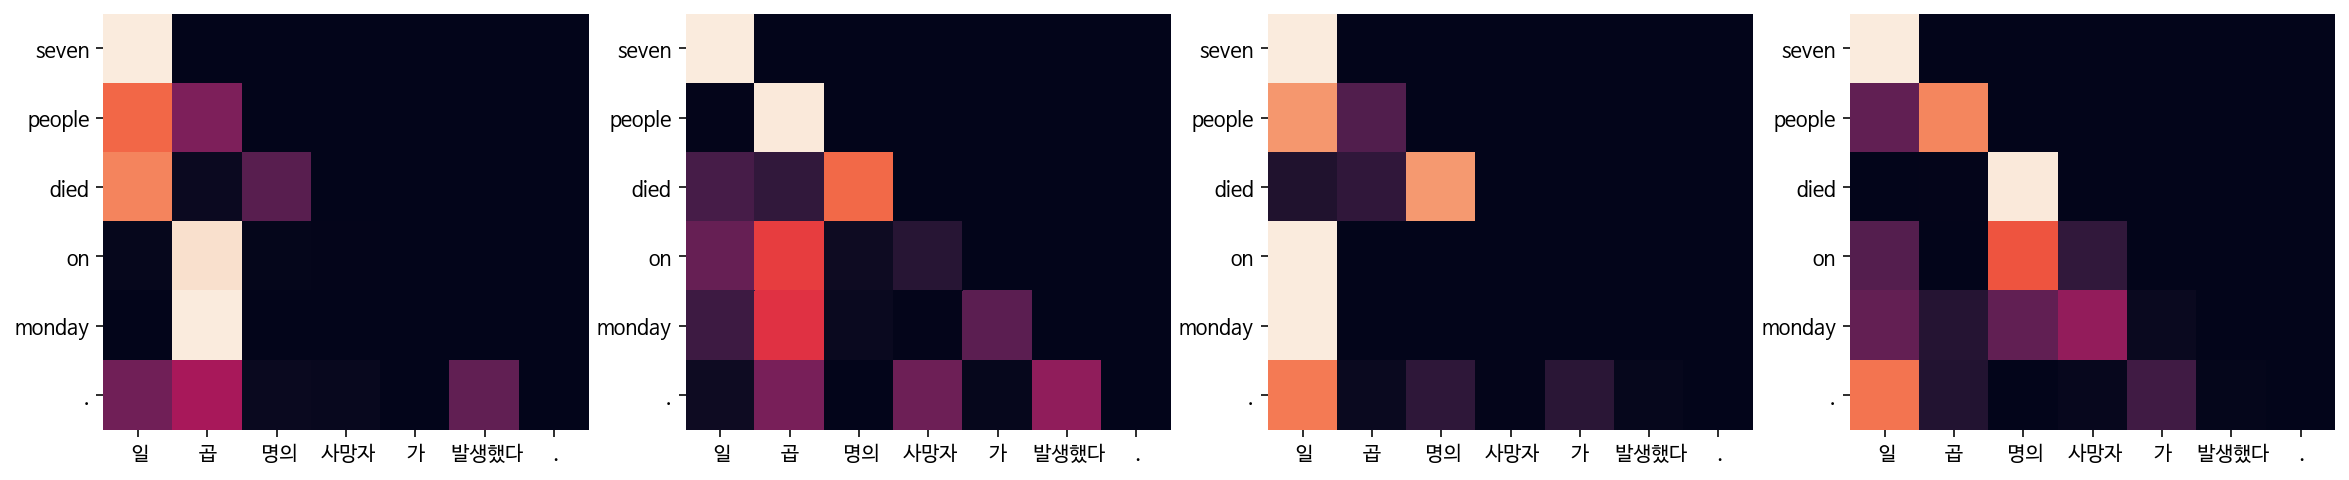

Decoder Self Layer 2


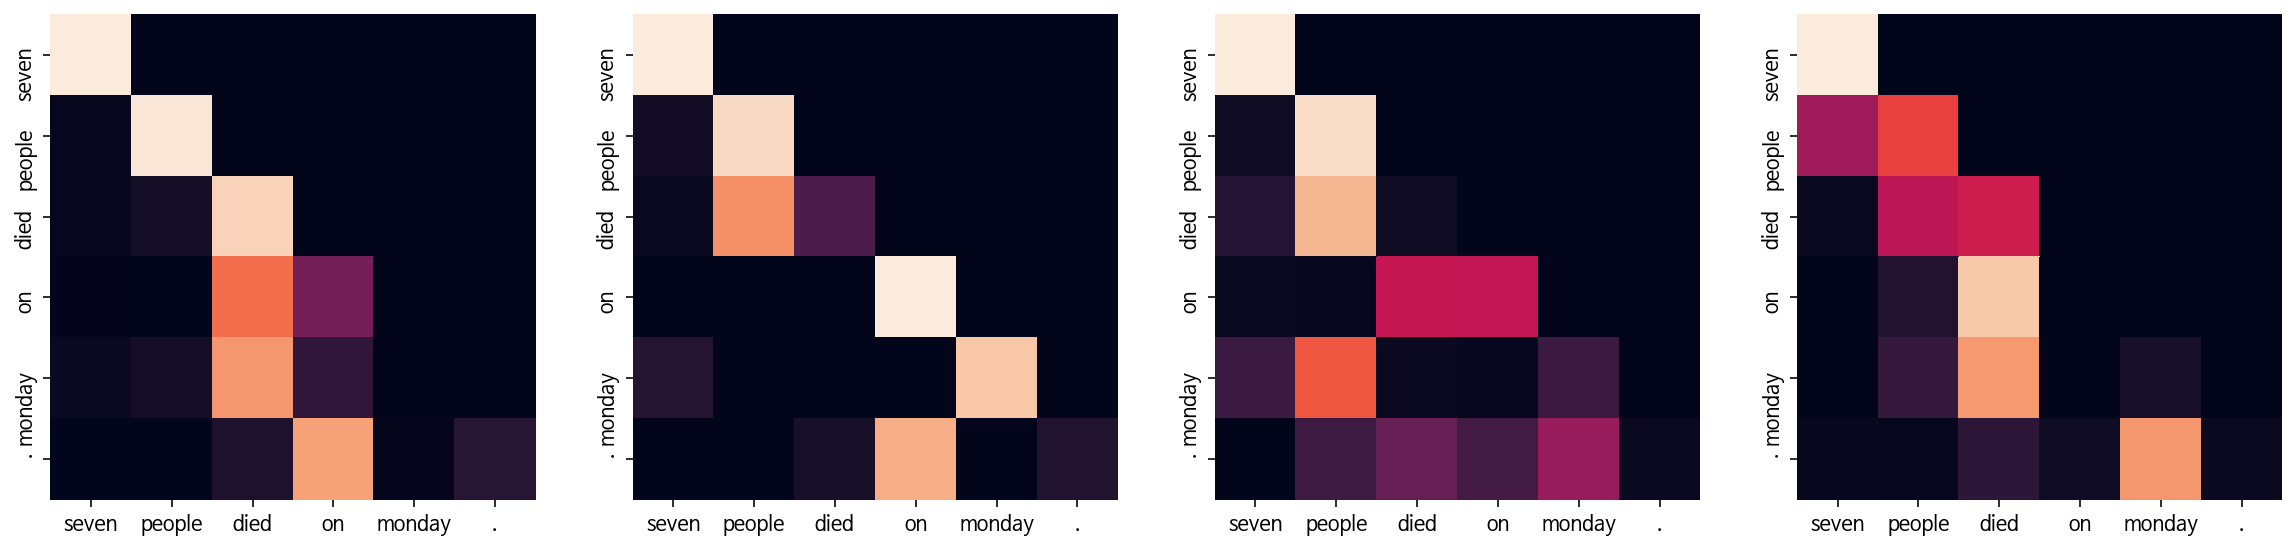

Decoder Src Layer 2


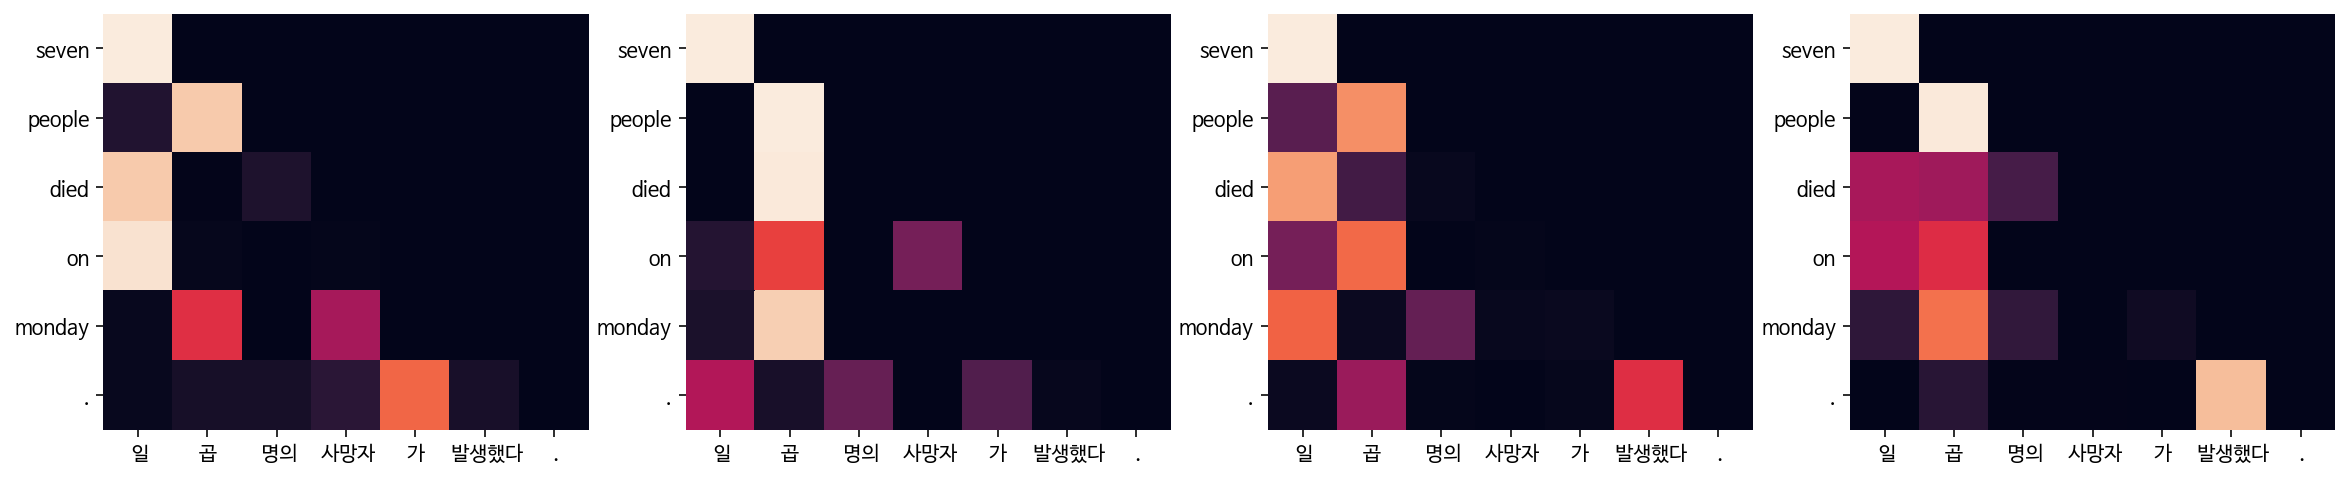

In [32]:
translate(sen, transformer, kor_tokenizer, eng_tokenizer, plot_attention = True)